In [1]:
import numpy as np
import torchvision
from torchvision.transforms import Compose, Resize, ToTensor, Normalize, PILToTensor, CenterCrop, ConvertImageDtype
from skimage import io
import torch
import torch.nn as nn
from einops import rearrange, repeat
import pandas as pd
import sys
sys.path.insert(0, '../utils/')
from dataset import ChestImage64
import os
import time
import datetime

from PIL import Image

import matplotlib.pyplot as plt
import csv

from torchvision.models import vit_b_16, ViT_B_16_Weights
from torch.utils.data import random_split, DataLoader, Dataset

In [2]:
# csv_path = "../64pxImages/train_labels_64p.csv"
# root_path = '../64pxImages'

csv_path = "../Data/256pxImages/train_labels_256p.csv" #I had to change \ to / for this but disregared if it is not an issue for you
root_path = "../Data/256pxImages/"


#default_transform = ViT_B_16_Weights.IMAGENET1K_SWAG_LINEAR_V1.transforms


#data_transform = Compose([
    #Resize((64, 64)),
    #ToTensor(),
    #Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
#])

In [3]:
myCSV = pd.read_csv(csv_path)
myCSV['EncodedLabels'] = ''
print(myCSV.shape)


# for i in range(4, myCSV.shape[1]-1):
#     myCSV['EncodedLabels'] = myCSV['EncodedLabels'].astype(str) + myCSV.iloc[:, i].astype(str) 
#     if i < myCSV.shape[1]-2:
#         myCSV['EncodedLabels'] = myCSV['EncodedLabels'].astype(str) + "," 

for i in range(4, myCSV.shape[1]-1):
    myCSV['EncodedLabels'] = myCSV['EncodedLabels'].astype(str) + myCSV.iloc[:, i].astype(str) 
    if i < myCSV.shape[1]-2:
        myCSV['EncodedLabels'] = myCSV['EncodedLabels'].astype(str) + "," 



# myCSV['EncodedLabels'] = myCSV['EncodedLabels'].astype(str) + "]"


# We can use the encodedlabels column as our labels for our data

# since we are not useing cross attention, pull out only the frontal images. 
frontalCSV = myCSV[myCSV['Frontal/Lateral'].str.contains("Frontal")]
frontalCSV.head()

filename = frontalCSV.iloc[1, 0]
print(filename)

label_test = frontalCSV['EncodedLabels'].iloc[0]

test_path = os.path.join(root_path, filename)


label_test = [int(x) for x in label_test.split(",")]

print("label_test: ", label_test)

image = io.imread(test_path)
print(type(image))
image = torch.tensor(image)
print(image.size())

(61266, 19)
Frontal\patient00004_study1_Frontal.png
label_test:  [1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0]
<class 'numpy.ndarray'>
torch.Size([256, 256])


In [4]:
lateralCSV = myCSV[myCSV['Frontal/Lateral'].str.contains("Lateral")]
lateralCSV.head()


,256path,Patient,Study,Frontal/Lateral,Enlarged Cardiomediastinum,Cardiomegaly,Lung Opacity,Lung Lesion,Edema,Consolidation,Pneumonia,Atelectasis,Pneumothorax,Pleural Effusion,Pleural Other,Fracture,Support Devices,No Finding,EncodedLabels
1,Lateral\patient00002_study1_Lateral.png,patient00002,study1,Lateral,1,1,1,1,0,1,1,1,0,0,1,1,0,0,"1,1,1,1,0,1,1,1,0,0,1,1,0,0"
3,Lateral\patient00004_study1_Lateral.png,patient00004,study1,Lateral,0,0,0,0,0,0,0,0,0,0,0,0,0,1,"0,0,0,0,0,0,0,0,0,0,0,0,0,1"
5,Lateral\patient00005_study1_Lateral.png,patient00005,study1,Lateral,0,0,0,0,0,0,0,0,0,0,0,0,1,0,"0,0,0,0,0,0,0,0,0,0,0,0,1,0"
7,Lateral\patient00009_study1_Lateral.png,patient00009,study1,Lateral,1,1,0,0,0,0,0,0,0,0,0,0,0,0,"1,1,0,0,0,0,0,0,0,0,0,0,0,0"
9,Lateral\patient00010_study1_Lateral.png,patient00010,study1,Lateral,0,0,0,0,0,0,0,0,0,0,0,0,0,1,"0,0,0,0,0,0,0,0,0,0,0,0,0,1"


In [5]:
myCSV.head()

,256path,Patient,Study,Frontal/Lateral,Enlarged Cardiomediastinum,Cardiomegaly,Lung Opacity,Lung Lesion,Edema,Consolidation,Pneumonia,Atelectasis,Pneumothorax,Pleural Effusion,Pleural Other,Fracture,Support Devices,No Finding,EncodedLabels
0,Frontal\patient00002_study1_Frontal.png,patient00002,study1,Frontal,1,1,1,1,0,1,1,1,0,0,1,1,0,0,"1,1,1,1,0,1,1,1,0,0,1,1,0,0"
1,Lateral\patient00002_study1_Lateral.png,patient00002,study1,Lateral,1,1,1,1,0,1,1,1,0,0,1,1,0,0,"1,1,1,1,0,1,1,1,0,0,1,1,0,0"
2,Frontal\patient00004_study1_Frontal.png,patient00004,study1,Frontal,0,0,0,0,0,0,0,0,0,0,0,0,0,1,"0,0,0,0,0,0,0,0,0,0,0,0,0,1"
3,Lateral\patient00004_study1_Lateral.png,patient00004,study1,Lateral,0,0,0,0,0,0,0,0,0,0,0,0,0,1,"0,0,0,0,0,0,0,0,0,0,0,0,0,1"
4,Frontal\patient00005_study1_Frontal.png,patient00005,study1,Frontal,0,0,0,0,0,0,0,0,0,0,0,0,1,0,"0,0,0,0,0,0,0,0,0,0,0,0,1,0"


torch.Size([3, 224, 224])
tensor([[[ 0.1254, -0.0801,  0.0056,  ...,  0.1939,  0.2453,  0.0398],
         [ 0.1083, -0.0116,  0.0227,  ...,  0.0569,  0.1426, -0.0629],
         [ 0.1083, -0.0116, -0.0116,  ...,  0.1597,  0.0056, -0.0801],
         ...,
         [-1.0390, -1.0219, -1.0390,  ..., -1.8097, -1.8097, -1.7925],
         [-1.0562, -1.0733, -1.0562,  ..., -1.8097, -1.7925, -1.7925],
         [-1.0390, -0.9877, -0.9877,  ..., -1.7925, -1.7754, -1.7583]],

        [[ 0.2577,  0.0476,  0.1352,  ...,  0.3277,  0.3803,  0.1702],
         [ 0.2402,  0.1176,  0.1527,  ...,  0.1877,  0.2752,  0.0651],
         [ 0.2402,  0.1176,  0.1176,  ...,  0.2927,  0.1352,  0.0476],
         ...,
         [-0.9328, -0.9153, -0.9328,  ..., -1.7206, -1.7206, -1.7031],
         [-0.9503, -0.9678, -0.9503,  ..., -1.7206, -1.7031, -1.7031],
         [-0.9328, -0.8803, -0.8803,  ..., -1.7031, -1.6856, -1.6681]],

        [[ 0.4788,  0.2696,  0.3568,  ...,  0.5485,  0.6008,  0.3916],
         [ 0.4614, 

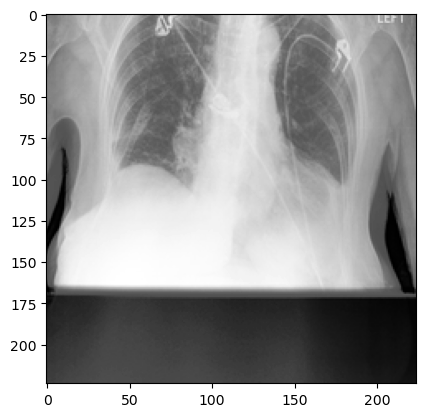

In [6]:
filenameTest = frontalCSV.iloc[0, 0]
testpath = os.path.join(root_path, filenameTest)
testimg = Image.open(testpath).convert('RGB')
#plt.imshow(testimg)
#testimg = torch.tensor(testimg)
testtransform = Compose([
    PILToTensor(),
    CenterCrop((224,224)),
    ConvertImageDtype(torch.float32),
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
testimg = testtransform(testimg)
#testimg = testimg.resize_((3, 224, 224))
#testimg = repeat(testimg, "h w -> (repeat h) w", repeat = 3)
#testimg = rearrange(testimg, "(c h) w -> c h w", c = 3)
print(testimg.size())
print(testimg)

plt.imshow(testimg.numpy()[0], cmap='gray')

torch.Size([3, 224, 224])
tensor([[[-1.2445, -1.2788, -1.3815,  ..., -1.9809, -1.9809, -1.9295],
         [-1.1589, -1.2445, -1.3987,  ..., -1.9809, -1.9809, -1.9467],
         [-1.3644, -1.3815, -1.4500,  ..., -2.0323, -1.9980, -1.9809],
         ...,
         [-0.5424, -0.4054, -0.3541,  ..., -1.7583, -1.7583, -1.7583],
         [-0.6281, -0.6109, -0.6281,  ..., -1.7583, -1.7583, -1.7583],
         [-0.4054, -0.4739, -0.6281,  ..., -1.7754, -1.7754, -1.7754]],

        [[-1.1429, -1.1779, -1.2829,  ..., -1.8957, -1.8957, -1.8431],
         [-1.0553, -1.1429, -1.3004,  ..., -1.8957, -1.8957, -1.8606],
         [-1.2654, -1.2829, -1.3529,  ..., -1.9482, -1.9132, -1.8957],
         ...,
         [-0.4251, -0.2850, -0.2325,  ..., -1.6681, -1.6681, -1.6681],
         [-0.5126, -0.4951, -0.5126,  ..., -1.6681, -1.6681, -1.6681],
         [-0.2850, -0.3550, -0.5126,  ..., -1.6856, -1.6856, -1.6856]],

        [[-0.9156, -0.9504, -1.0550,  ..., -1.6650, -1.6650, -1.6127],
         [-0.8284, 

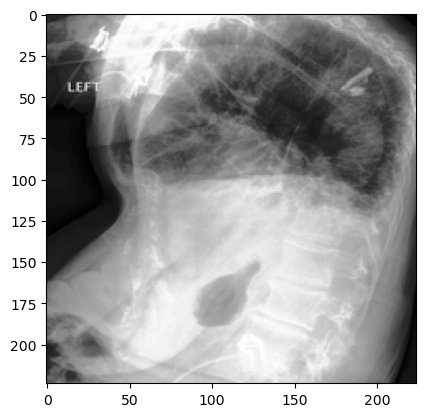

In [7]:
filenameTest = lateralCSV.iloc[0, 0]
testpath = os.path.join(root_path, filenameTest)
testimg = Image.open(testpath).convert('RGB')
#plt.imshow(testimg)
#testimg = torch.tensor(testimg)
testtransform = Compose([
    PILToTensor(),
    CenterCrop((224,224)),
    ConvertImageDtype(torch.float32),
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
testimg = testtransform(testimg)
#testimg = testimg.resize_((3, 224, 224))
#testimg = repeat(testimg, "h w -> (repeat h) w", repeat = 3)
#testimg = rearrange(testimg, "(c h) w -> c h w", c = 3)
print(testimg.size())
print(testimg)

plt.imshow(testimg.numpy()[0], cmap='gray')

In [8]:
# load up the dataset
class CustomDataset(Dataset):
    def __init__(self, df, root_dir, label_col, transform = None):
        self.df = df
        self.root_dir = root_dir
        self.label_col = label_col
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, index):

        if torch.is_tensor(index):
            index = index.tolist()

        # get the filename of the image
        filename = self.df.iloc[index, 0]
        label = self.df[self.label_col].iloc[index]

        if type(label) == str:
            label = [int(x) for x in label.split(",")]

        # load the image from disk
        path = os.path.join(self.root_dir, filename)
        img = Image.open(path).convert('RGB')

        label = torch.tensor(label)
        label = label.float()

        img = self.transform(img)


        # return the image and its filename
        return img, label

In [9]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [10]:
def transform_val(input):
    if input < 0:
        x = 0.0
    else:
        x = 1.0
    return x    

In [11]:
def train_model(train_dataset, val_dataset, test_dataset,config, type="Frontal", benchmark=0.33):
    #, epochs=1
    start_time = time.time()
    
    learning_rate=config["lr"]
    batch_size=config["batch_size"]
    #dropout=config["d1"]
    epochs=config["epochs"]
    
    
    # batch accumulation parameter
    target_accumulation=batch_size
    accum_iter = target_accumulation/batch_size  
    print(accum_iter)

    
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(test_dataset,batch_size=batch_size, shuffle=True)
    
    
    # information about the pretrained models is coming from this link: 
    #https://pytorch.org/vision/master/models.html


    # just use the default weights. These should yeild the best results
    weights = ViT_B_16_Weights.DEFAULT
    num_classes = 14
    feature_extraction = True
    model = vit_b_16(weights = weights)
    
    criterion = nn.BCEWithLogitsLoss()
    
    if feature_extraction: 
        for param in model.parameters():
            param.requires_grad = False

        # change the last layer to have the correct number of classes
        model.heads = nn.Sequential(nn.Linear(768, num_classes))
        model.heads.requires_grad_ = True
    else:
        model.heads = nn.Sequential(nn.Linear(768, num_classes))

    
    model.to(device)

    
    optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9) 
    
    training_losses = []
    validation_losses = []
    #validation_accuracies =[]
    global v_running_loss #maybe not a good idea?

    
    for epoch in range(epochs):
        phase = 'train'
        # set the model to training mode
        model.train()
        running_loss = 0.0

        # zero the parameter gradients at the very beginning
        optimizer.zero_grad()

        for i, data in enumerate(train_loader):
            inputs, labels = data[0].to(device), data[1].to(device)

            # zero the parameter gradients
            # optimizer.zero_grad()

            # with torch.set_grad_enabled(phase == 'train'):
            # run the training data through the model
            outputs = model(inputs)

            #calculate the loss of the model
            loss = criterion(outputs, labels)

            #Gradient accumulation
            loss.backward()

            running_loss += loss.item()

            # weights update
            if ((i + 1) % accum_iter == 0) or (i + 1 == len(train_loader)):
                optimizer.step()
                optimizer.zero_grad()

                if ((i + 1) * batch_size) % 9600 == 0:    # record loss and test validation set every 9600 images
                    model.eval()
                    v_running_loss = 0.0
                    for v, data in enumerate(val_loader):
                        inputs, labels = data[0].to(device), data[1].to(device)
                        v_outputs = model(inputs)
                        v_loss = criterion(v_outputs, labels)
                        v_running_loss += v_loss.item()

                    print("Time: ", datetime.datetime.now().strftime("%H:%M:%S"), "\tepoch: ", epoch+1, "batch: ", i+1, "Training loss: ", running_loss, "Validation loss ", v_running_loss)
                    validation_losses.append(v_running_loss)
                    training_losses.append(running_loss)
                    running_loss = 0.0

                # once the validation has been completed, update the model
                # set model back to training mode

    end_time = time.time()
    train_time = end_time - start_time
    print("Elapsed Training Time: ", datetime.timedelta(seconds = train_time))
    print('Finished Training')
    
    #model_name= "vitb_model_e" + str(epochs) + f"_drop{dropout:.0e}" + f"_lr{learning_rate:.0e}" + "_bs "+ str(batch_size)
    model_name= type + "_vitb_model_fe_e" + str(epochs) + f"_lr{learning_rate:.0e}" + "_bs "+ str(batch_size)
    model_filepath="../Logging/" + model_name + ".pth"

    figure_path="../Logging/" + model_name + ".png"

    print(model_filepath)

    torch.save(model.state_dict(), model_filepath)

    fig, axs = plt.subplots()
    axs.plot(training_losses)
    axs.plot(validation_losses)
    axs.set_title("Losses")
    axs.set_xlabel("x 9600 Samples")
    axs.set_ylabel("Loss")

    fig.suptitle(model_name)
    plt.savefig(figure_path, dpi=300)


    # now that the training has been complete, let's run through this baby with our test set.
    # put the model back in evaluation mode. 
    # now run the validation set once more to pull out the mis-typed images. 
    model.eval()
    total = 0.0
    v_corc_arr = np.zeros((1,14))
    v_acc_string = "_"

    for v, vdata in enumerate(test_loader):
        vinputs, vlabels = vdata[0].to(device), vdata[1].to(device)
        voutputs = model(vinputs)
        for i in range(voutputs.shape[0]):
            total += 1
            for j in range(voutputs.shape[1]):
                if transform_val(voutputs[i,j].cpu().detach().numpy()) == vlabels[i,j].cpu().detach().numpy():
                    v_corc_arr[0,j] = v_corc_arr[0,j] + 1
    
    v_corc_arr=v_corc_arr/total

    for acc in range(14):
        v_acc_string = v_acc_string + "/" + str(v_corc_arr[0,acc])
    
    #return running_loss, v_running_loss, accuracy, epoch
    return running_loss, v_running_loss, v_acc_string, epoch
    

In [12]:
testtransform = Compose([
    PILToTensor(),
    CenterCrop((224,224)),
    ConvertImageDtype(torch.float32),
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    
datasetFront = CustomDataset(frontalCSV, root_dir=root_path, label_col="EncodedLabels", transform=testtransform)
datasetLat = CustomDataset(lateralCSV, root_dir=root_path, label_col="EncodedLabels", transform=testtransform)


#print(type(dataset))

# split into test train validate
train_size_front = int(0.7 * len(datasetFront))
val_size_front = int(0.1 * len(datasetFront))
test_size_front=len(datasetFront)-train_size_front-val_size_front

train_size_lat= int(0.7 * len(datasetLat))
val_size_lat = int(0.1 * len(datasetLat))
test_size_lat=len(datasetLat)-train_size_lat-val_size_lat


train_dataset_front, val_dataset_front, test_dataset_front = random_split(datasetFront, [train_size_front, val_size_front, test_size_front])
train_dataset_lat, val_dataset_lat, test_dataset_lat = random_split(datasetLat, [train_size_lat, val_size_lat, test_size_lat])

print("Train Length: ", len(train_dataset_front))
print("Validation Length: ", len(val_dataset_front))
print("Test Length: ", len(test_dataset_front))

print("Train Length: ", len(train_dataset_lat))
print("Validation Length: ", len(val_dataset_lat))
print("Test Length: ", len(test_dataset_lat))

#train_loader = DataLoader(train_dataset, batch_size=batchsize, shuffle=True)
#val_loader = DataLoader(val_dataset, batch_size=batchsize, shuffle=False)
#test_loader = DataLoader(test_dataset,batch_size=batchsize, shuffle=True)

Train Length:  21441
Validation Length:  3063
Test Length:  6126
Train Length:  21445
Validation Length:  3063
Test Length:  6128


{'epochs': 1, 'lr': 0.003, 'batch_size': 16}
Train Start. Iteration:  1
1.0
Time:  21:26:35 	epoch:  1 batch:  600 Training loss:  304.0374719798565 Validation loss  92.12384113669395
Time:  21:27:31 	epoch:  1 batch:  1200 Training loss:  281.9155885875225 Validation loss  88.59393879771233
Elapsed Training Time:  0:02:08.766426
Finished Training
../Logging/Frontal_vitb_model_fe_e1_lr3e-03_bs 16.pth
{'epochs': 1, 'lr': 0.003, 'batch_size': 16}
Train Start. Iteration:  2
1.0
Time:  21:29:18 	epoch:  1 batch:  600 Training loss:  306.27895787358284 Validation loss  91.21939125657082
Time:  21:30:15 	epoch:  1 batch:  1200 Training loss:  281.21200212836266 Validation loss  88.02415764331818
Elapsed Training Time:  0:02:06.396100
Finished Training
../Logging/Lateral_vitb_model_fe_e1_lr3e-03_bs 16.pth


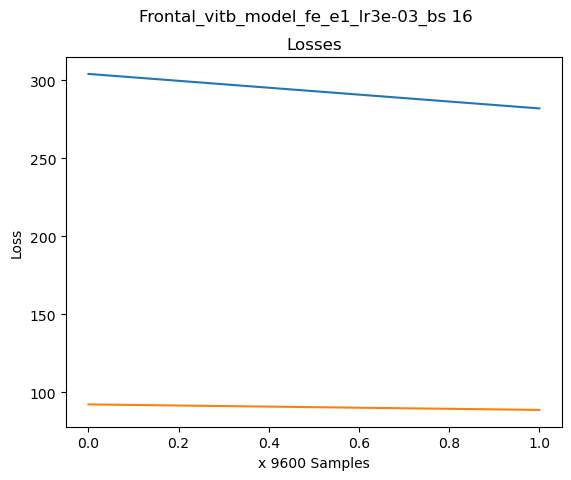

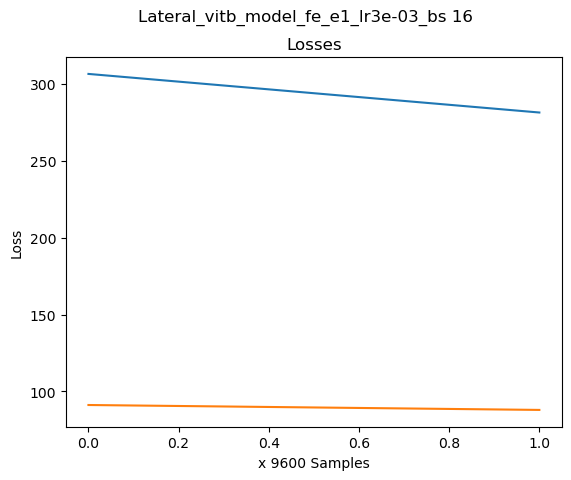

In [13]:
result_list = []

#Grid search parameters
#dropout=[0.2]
batch_size=[16]
learn_rate=[0.003]
epochs=[1]


it=0
#for d in dropout:
for e in epochs:
    for bs in batch_size:
        for lr in learn_rate:

            it +=1 
            config = {"epochs": e, "lr": lr, "batch_size": bs}

            print(config)
            print("Train Start. Iteration: ",it)
            t_loss,v_loss, v_acc_str, end_Ep=train_model(train_dataset_front, val_dataset_front, test_dataset_front, config,type="Frontal")

            list_row= "Front," + str(bs) + "," + str(lr) + "," + str(t_loss) + "," + str(v_loss) + "," + str(end_Ep) + "," + v_acc_str

            t_list=[list_row]  
            result_list.append(t_list)

for e in epochs:
    for bs in batch_size:
        for lr in learn_rate:

            it +=1 
            config = {"epochs": e, "lr": lr, "batch_size": bs}

            print(config)
            print("Train Start. Iteration: ",it)
            t_loss,v_loss, v_acc_str, end_Ep=train_model(train_dataset_lat, val_dataset_lat, test_dataset_lat, config,type="Lateral")

            list_row= "Lateral," +  str(bs) + "," + str(lr) + "," + str(t_loss) + "," + str(v_loss) + "," + str(end_Ep) + "," + v_acc_str

            t_list=[list_row]  
            result_list.append(t_list)            


with open('fe_opt_resultss.csv','w') as result_file:
    wr = csv.writer(result_file, dialect='excel')
    wr.writerow(result_list)